In [1]:
import numpy as np
import mass_balance as mb
from scipy import optimize
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
verbose = 1

In this test I sent up the distribution coefficients based on the input compositions - then the output compositions should not change. 

In [3]:
mb.rubie_example()

0.88 0.05 0.02 0.05
0.25 0.5 0.25
0.17600000000000002 0.011363636363636364 0.016141528925619836
SiO2 =  25.0 25.0
FeO  =  25.0 25.0
MgO  =  50.0 50.0
Fe   =  88.0 88
Si   =  5.0 5
O    =  5.0 5
Mg   =  2.0 2
Kd_Si=  0.016141528925619833 0.016141528925619836
Kd_Mg=  0.011363636363636364 0.011363636363636364
Kd_O =  0.17600000000000002 0.17600000000000002


8.001653684335672 1.5313840010500124 0.03717645579803449 0.0310170149947769
8.530746363010529 1.577723155150931 0.03467857110574729 0.027116102864350927
9.125806908575896 1.622243346931471 0.032001919814828826 0.023558060614681135
9.792855713144137 1.6627040866692062 0.02916169359690815 0.02033025645894689
10.537063052368007 1.6962173120491735 0.026184602429695805 0.017419046970785453
11.362005152902041 1.7192406596436587 0.023110836168825376 0.014809827498930062
12.268722150472138 1.7276774260732082 0.01999504512641746 0.01248709852743699
13.254626337573567 1.7171344013309437 0.01690557668842227 0.010434549033470339
14.312383095715502 1.6833776120982018 0.013921217674522089 0.00863515763974681
15.428977954194023 1.6229876367851266 0.011125010014663839 0.007071312006813009


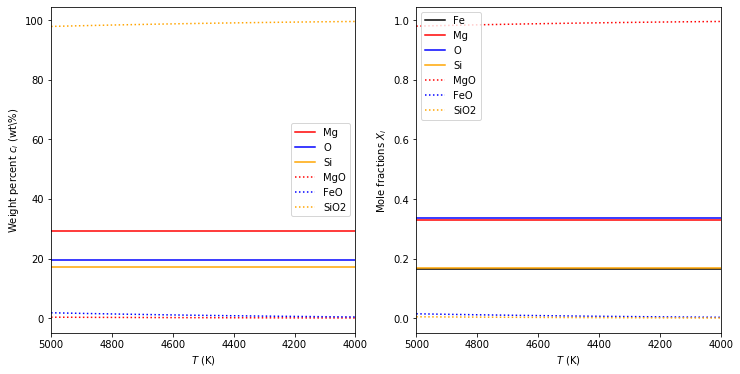

In [22]:
def dis_ex2(Tcmb):
    
    """Test dissolution codes against analytical soln
    b = Mg = 0 if a=0 
    b = const if KMg/KO = const
    x = 0 => kO = infty so disallowed"""
    
    a_Mg_B18, b_Mg_B18, c_Mg_B18 = 1.06  ,-12842, 0.0 # Dissolution
    Kd_Mg = 10**mb.logKd(a_Mg_B18, b_Mg_B18, c_Mg_B18, Tcmb)
    Kd_O  = np.ones(len(Tcmb))
    Kd_Si = np.ones(len(Tcmb))
    
    MFe  = 50 *np.ones(len(Tcmb)) #a
    MMg  = 50 *np.ones(len(Tcmb)) #b
    MO   = 50 *np.ones(len(Tcmb)) #c 
    MSi  = 50 *np.ones(len(Tcmb)) #d

    MFeO = 1 *np.ones(len(Tcmb)) #x
    MMgO = np.ones(len(Tcmb))    #y
    MSiO2= 1 *np.ones(len(Tcmb)) #z
    
    MFei, MOi, MSii, MMgi, MFeOi, MMgOi, MSiO2i = MFe[0], MO[0], MSi[0], MMg[0], MFeO[0], MMgO[0], MSiO2[0]
    
    bp = np.ones(len(Tcmb))
    cp = np.ones(len(Tcmb))
    yp = np.ones(len(Tcmb))
    
    tt = 0
    for t in Tcmb:    
 
        #MMgO[tt] = (2 + MFe[tt]*Kd_Mg[tt]) / (Kd_Mg[tt])
        MMgO[tt] = (2 + MFei*Kd_Mg[tt]) / (Kd_Mg[tt])
        
        bp[tt] = MFei*(MMgOi+MMgi) * (Kd_Mg[tt]/Kd_O[tt]) / (MFeOi + MFei*Kd_Mg[tt]/Kd_O[tt])
        yp[tt] = MMgO[tt] + MMgi - bp[tt] 
        cp[tt] = MMgO[tt] + MOi  - yp[tt]
        KO_pre  = MFei*cp[tt]    *(MFeOi + MSiO2i + yp[tt]) / ( MFeOi * (MFei + bp[tt] + cp[tt] + MSii)**2 )
        KSi_pre = MSii*cp[tt]**2 *(MFeOi + MSiO2i + yp[tt]) / ( MSiO2i* (MFei + bp[tt] + cp[tt] + MSii)**3 )
        KMg_pre = bp[tt]*cp[tt]  *(MFeOi + MSiO2i + yp[tt]) / ( yp[tt]* (MFei + bp[tt] + cp[tt] + MSii)**2 )
        
        print(KO_pre, KSi_pre, KMg_pre, Kd_Mg[tt])
        
        params, dissolution = mb.dissolution_closure()
        dissolution(MFeO[tt], Kd_Mg[tt], Kd_O[tt], Kd_Si[tt], MFe[tt], MMg[tt], 
                    MO[tt], MSi[tt], MFeO[tt], MMgO[tt], MSiO2[tt])
        
        MFe[tt] , MO[tt]  , MSi[tt]  , MMg[tt] = params['Fe'] , params['O']  , params['Si']  , params['Mg']
        MFeO[tt], MMgO[tt], MSiO2[tt]          = params['FeO'], params['MgO'], params['SiO2']
        Kd_Mg_new = params['KMg_new']
        Kd_Si_new = params['KSi_new'] 
        Kd_O_new  =  params['KO_new']
        

        #print(Kd_Mg[tt], Kd_Mg_new, Kd_Si_new, KSi_pre, Kd_O_new, KO_pre)
        
        #print(b[tt], MMg[tt], c[tt], MO[tt], y[tt], MMgO[tt])
        #print('Fe, O, Si, Mg, FeO, MgO, SiO2 = {:8.3f}{:8.3f}{:8.3f}{:8.3f}{:8.3f}{:8.3f}{:8.3f}'
        #      .format(MFe[tt], MO[tt], MSi[tt], MMg[tt], MFeO[tt], MMgO[tt], MSiO2[tt]))
        
        tt = tt + 1
        
    oM = [MFe, MO, MSi, MMg, MFeO, MMgO, MSiO2]
    oX = mb.get_molefractions(oM) 
    cO_c1  , cSi_c1  , cMg_c1  = mb.mole2mass_core(oX[0], oX[1], oX[2], oX[3]) 
    cFeO_m1, cSiO2_m1, cMgO_m1 = mb.mole2mass_mant(oX[4], oX[5], oX[6]) 
    oC = [0.0, cO_c1, cSi_c1, cMg_c1, cFeO_m1, cMgO_m1, cSiO2_m1]
     
    return oX, oC

Tcmb = np.linspace(5000, 4000, 10)
X, c = dis_ex2(Tcmb)

XFe, XO, XSi, XMg = X[0],X[1],X[2],X[3]
XFeO, XMgO, XSiO2 = X[4],X[5],X[6]
cFe, cO, cSi, cMg = c[0],c[1],c[2],c[3]
cFeO, cMgO, cSiO2 = c[4],c[5],c[6]

fig, ((ax3, ax2)) = plt.subplots(1, 2, figsize=(12,6))

ax3.set_xlim([5000,4000])
#ax3.set_ylim([0,3])       # To compare to the Du plot. 
ax3.set_xlabel("$T$ (K)")
ax3.set_ylabel("Weight percent $c_{i}$ (wt\%)")
ax3.plot(Tcmb, cMg*100, color='red'   , label="Mg")
ax3.plot(Tcmb, cO*100 , color='blue'  , label="O")
ax3.plot(Tcmb, cSi*100, color='orange', label="Si")
ax3.plot(Tcmb, cMgO*100 , color='red'   , label="MgO" , linestyle=':')
ax3.plot(Tcmb, cFeO*100 , color='blue'  , label="FeO" , linestyle=':')
ax3.plot(Tcmb, cSiO2*100, color='orange', label="SiO2", linestyle=':')
ax3.legend()

ax2.set_xlim([5000,4000])
ax2.set_xlabel("$T$ (K)")
ax2.set_ylabel("Mole fractions $X_{i}$ ")
ax2.plot(Tcmb, XFe  , color='black' , label="Fe")
ax2.plot(Tcmb, XMg  , color='red'   , label="Mg")
ax2.plot(Tcmb, XO   , color='blue'  , label="O")
ax2.plot(Tcmb, XSi  , color='orange', label="Si")
ax2.plot(Tcmb, XMgO , color='red'   , label="MgO" , linestyle=':')
ax2.plot(Tcmb, XFeO , color='blue'  , label="FeO" , linestyle=':')
ax2.plot(Tcmb, XSiO2, color='orange', label="SiO2", linestyle=':')
ax2.legend(loc=2)

Initial core mole fractions of Fe  =   0.87 O   =   0.05 Mg   =   0.08 Si  =   0.00 All =   1.00
Initial mant mole fractions of FeO =   0.10 MgO =   0.80 SiO2 =   0.10 all =   1.00
Initial core mass fractions of O   =   1.57 Mg  =   0.00 Si  =   4.50
Initial mant mass fractions of FeO =   0.00 MgO =   0.00 SiO2 =   0.00
Dissolution


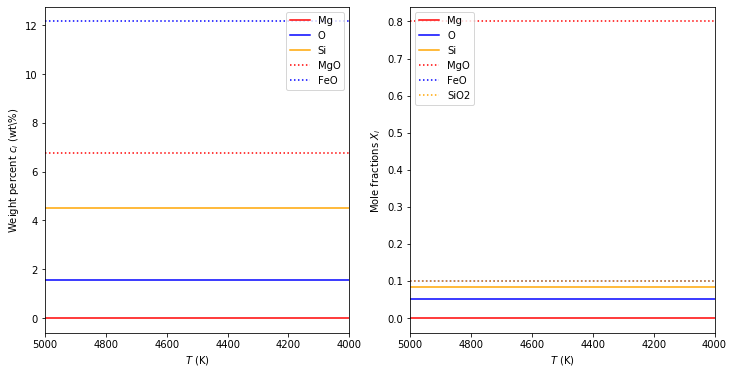

In [5]:
def b18_example():

    """Try to reproduce fig 3 of B18 using this code. 
    Set Kd_O and Kd_Si based on equilibrium concentrations to ensure no FeO and SiO2 exchange
    Mantle is 50 mol % pyrolite
    Core is 3 wt% O and 3 wt % Si
    """    
    Mtot = 100
    MFe  = 188#XFe_c * Mtot
    MO   = 11 #XO_c  * Mtot
    MSi  = 18 #XSi_c * Mtot
    MMg  = 0 #XMg_c * Mtot

    MFeO = 0.10  * Mtot
    MMgO = 0.8   * Mtot
    MSiO2= 0.10  * Mtot
    
    XO_c    = MO /(MFe+MO+MSi+MMg)
    XFe_c   = MFe/(MFe+MO+MSi+MMg)
    XSi_c   = MSi/(MFe+MO+MSi+MMg)
    XMg_c   = MMg/(MFe+MO+MSi+MMg)
    XFeO_m  = MFeO /(MFeO+MMgO+MSiO2)
    XMgO_m  = MMgO /(MFeO+MMgO+MSiO2)
    XSiO2_m = MSiO2/(MFeO+MMgO+MSiO2)
    
    cO_c, cSi_c, cMg_c  = mb.mole2mass_core(XFe_c, XO_c, XSi_c, XMg_c)
    mb.print_init_conc([XFe_c,XO_c,XSi_c,XMg_c,XFeO_m,XMgO_m,XSiO2_m],[0.0,cO_c,cSi_c,cMg_c,0.0,0.0,0.0])
    
    Kd_O    = XO_c  * XFe_c   / XFeO_m  * np.ones(len(Tcmb))
    Kd_Si   = XSi_c * XO_c**2 / XSiO2_m * np.ones(len(Tcmb))
    Kd_Mg   = XMg_c * XO_c    / XMgO_m  * np.ones(len(Tcmb))

    a_Mg_B18, b_Mg_B18, c_Mg_B18 = 1.06  ,-12842, 0.0 # Dissolution
    # Commenting out the next line shows that nothing gets exchanged - tick!
    #Kd_Mg = 10**mb.logKd(a_Mg_B18, b_Mg_B18, c_Mg_B18, Tcmb)
    
    iM = [MFe, MO, MSi, MMg, MFeO, MMgO, MSiO2]
    sol1 = mb.run_massbalance(iM, [Kd_Mg, Kd_O, Kd_Si], Tcmb, 2)
    
    return sol1

Tcmb = np.linspace(5000, 4000, 10)
sol1 = b18_example()

if verbose == 1:
    
    XFe, XO, XSi, XMg = sol1[1][0],sol1[1][1],sol1[1][2],sol1[1][3]
    XFeO, XMgO, XSiO2 = sol1[1][4],sol1[1][5],sol1[1][6]

    cFe, cO, cSi, cMg = sol1[3][0],sol1[3][1],sol1[3][2],sol1[3][3]
    cFeO, cMgO, cSiO2 = sol1[3][4],sol1[3][5],sol1[3][6]
    
    fig, ((ax3, ax2)) = plt.subplots(1, 2, figsize=(12,6))
    
    ax3.set_xlim([5000,4000])
    #ax3.set_ylim([0,10])       # To compare to the Du plot. 
    ax3.set_xlabel("$T$ (K)")
    ax3.set_ylabel("Weight percent $c_{i}$ (wt\%)")
    ax3.plot(Tcmb, cMg*100, color='red'   , label="Mg")
    ax3.plot(Tcmb, cO*100 , color='blue'  , label="O")
    ax3.plot(Tcmb, cSi*100, color='orange', label="Si")
    ax3.plot(Tcmb, cMgO*100 , color='red'   , label="MgO" , linestyle=':')
    ax3.plot(Tcmb, cFeO*100 , color='blue'  , label="FeO" , linestyle=':')
    #ax3.plot(Tcmb, cSiO2*100, color='orange', label="SiO2", linestyle=':')
    ax3.legend()

    ax2.set_xlim([5000,4000])
    #ax2.set_ylim([0,0.5])       # To compare to the Du plot. 
    ax2.set_xlabel("$T$ (K)")
    ax2.set_ylabel("Mole fractions $X_{i}$ ")
    ax2.plot(Tcmb, XMg  , color='red'   , label="Mg")
    ax2.plot(Tcmb, XO   , color='blue'  , label="O")
    ax2.plot(Tcmb, XSi  , color='orange', label="Si")
    ax2.plot(Tcmb, XMgO , color='red'   , label="MgO" , linestyle=':')
    ax2.plot(Tcmb, XFeO , color='blue'  , label="FeO" , linestyle=':')
    ax2.plot(Tcmb, XSiO2, color='orange', label="SiO2", linestyle=':')
    ax2.legend(loc=2)

In [6]:
# Data taken from Extended Data Table 1
a_Mg_OS, b_Mg_OS, c_Mg_OS = 0.1,-10851,0.0  # OS16
a_Si_OS, b_Si_OS, c_Si_OS = 1.3,-13500,0.0  # Originally from Fischer et al 2015
a_O_OS , b_O_OS , c_O_OS  = 0.6,-3800 ,22.0 # Originally from Fischer et al 2015

Tcmb = np.linspace(6000,2000,1001)
dT = Tcmb[0]-Tcmb[1]

Kd_Mg      = 10**mb.logKd(a_Mg_OS, b_Mg_OS, c_Mg_OS, Tcmb)   
Kd_O       = 10**mb.logKd(a_O_OS , b_O_OS , c_O_OS , Tcmb) 
Kd_Si      = 10**mb.logKd(a_Si_OS, b_Si_OS, c_Si_OS, Tcmb) 

verbose = 1

In [7]:
MFei, MOi, MSii, MMgi = 79, 19, 5, 4 # Default composition
MFeOi, MMgOi, MSiO2i  = 30, 50, 8

params, rubie = mb.rubie_closure()

#optimize.brentq(rubie, -0.01, 100, args=(Kd_Mg[0], Kd_O[0], Kd_Si[0], MFei, 
#                                                  MMgi, MOi, MSii, MFeOi, MMgOi, MSiO2i))

Multiply all moles by 10 - shows that result does not depend on the number of moles, just the compositions. 

BUT - need to do this to all both core and mantle compositions else you change the relative masses of core and mantle and this does affect the result. 

Core mass = 1.94e24 kg \
Mant mass = 4.01e24 kg

In [8]:
# Input composition
iMFe, iMO, iMSi, iMMg = 79, 19, 5, 4 # Default composition
iMFeO, iMMgO, iMSiO2  = 30, 50, 8
iM = [iMFe, iMO, iMSi, iMMg, iMFeO, iMMgO, iMSiO2]
sol1 = mb.run_massbalance(iM, [Kd_Mg, Kd_O, Kd_Si], Tcmb, 1)

# Input composition
iMFe, iMO, iMSi, iMMg = 158, 38, 10, 8 # Default composition
iMFeO, iMMgO, iMSiO2  = 60, 100, 16
iM = [iMFe, iMO, iMSi, iMMg, iMFeO, iMMgO, iMSiO2]
sol2 = mb.run_massbalance(iM, [Kd_Mg, Kd_O, Kd_Si], Tcmb, 1)

# Input composition * 10
iMFe, iMO, iMSi, iMMg = 79, 19, 5, 4
iMFeO, iMMgO, iMSiO2  = 60, 100, 16
iM = [iMFe, iMO, iMSi, iMMg, iMFeO, iMMgO, iMSiO2]
sol3 = mb.run_massbalance(iM, [Kd_Mg, Kd_O, Kd_Si], Tcmb, 1)

Initial core mole fractions of Fe  =   0.74 O   =   0.18 Mg   =   0.05 Si  =   0.04 All =   1.00
Initial mant mole fractions of FeO =   0.34 MgO =   0.57 SiO2 =   0.09 all =   1.00
Initial core mass fractions of O   =   6.12 Mg  =   1.93 Si  =   2.82
Initial mant mass fractions of FeO =  39.42 MgO =   5.84 SiO2 =  54.74
Initial core mole fractions of Fe  =   0.74 O   =   0.18 Mg   =   0.05 Si  =   0.04 All =   1.00
Initial mant mole fractions of FeO =   0.34 MgO =   0.57 SiO2 =   0.09 all =   1.00
Initial core mass fractions of O   =   6.12 Mg  =   1.93 Si  =   2.82
Initial mant mass fractions of FeO =  39.42 MgO =   5.84 SiO2 =  54.74

Core mole fractions of Fe  =   0.79 O   =   0.21 Mg   =   0.00 Si  =   0.00 All =   1.00
Mant mole fractions of FeO =   0.11 MgO =   0.72 SiO2 =   0.17 all =   1.00
Core mass fractions of O   =   7.07 Mg  =   0.00 Si  =   0.00
Mant mass fractions of FeO =  13.50 MgO =  11.96 SiO2 =  74.54
Core mole fractions of Fe  =   0.79 O   =   0.21 Mg   =   0.00 Si

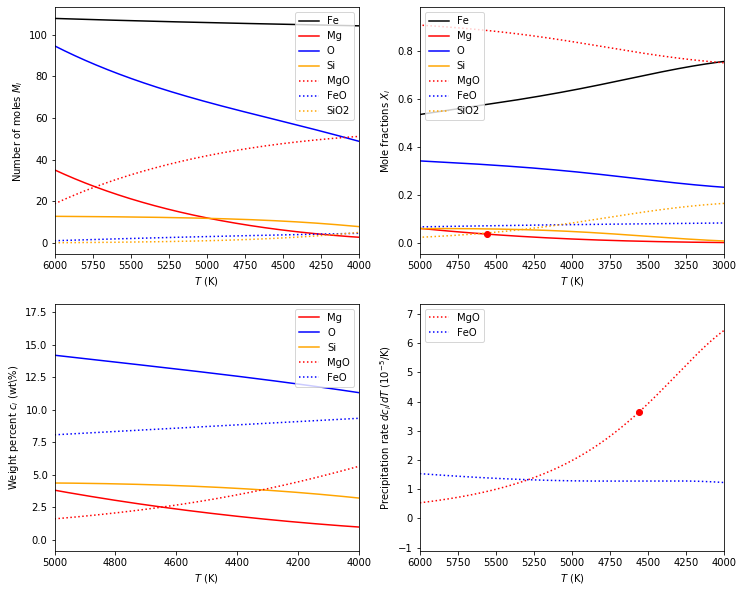

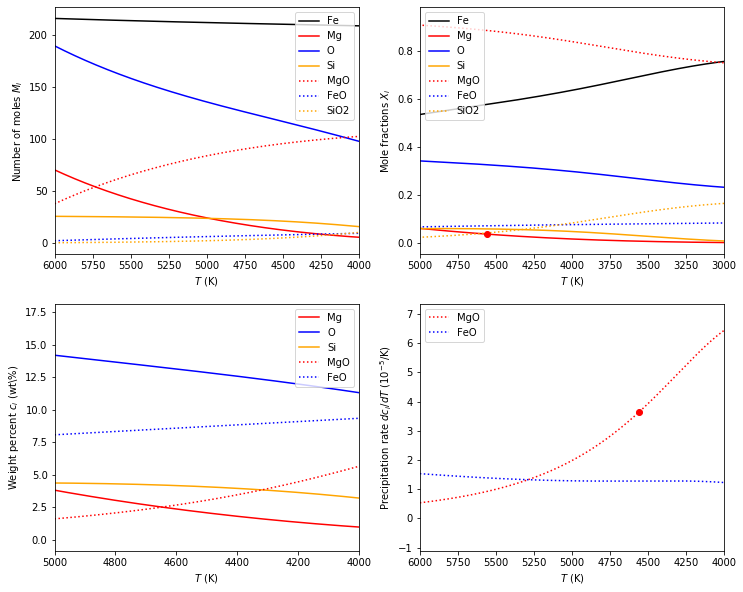

In [9]:
if verbose == 1:
    mb.print_init_conc(sol1[0],sol1[2])
    mb.print_init_conc(sol2[0],sol2[2])
    print("")
    mb.print_any_conc(sol1[1],sol1[3],-1)
    mb.print_any_conc(sol2[1],sol2[3],-1)
    mb.plot_all(Tcmb, sol1[5], sol1[1], sol1[3], sol1[4])
    mb.plot_all(Tcmb, sol2[5], sol2[1], sol2[3], sol2[4])